#Traductor Español - Otomí
*   Lázaro Martínez Abraham Josué
*   abrahamlazaro@comunidad.unam.mx



# Preparativos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sacrebleu
from sacrebleu.metrics import BLEU
import os
os.chdir("/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/transformer_lazaro")
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from transformer import *

     |████████████████████████████████| 90 kB 4.0 MB/s 


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Preprocesamiento de datos

## Funciones

In [ ]:
# Simbolos especiales
PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2
OOV_IDX = 3

# Crea un diccionario de palabras con un indice
def vocab():
  dict_voc = defaultdict()
  # Cuando se haga referencia a una llave que no existe, default_factory
  # indicará que se debe hacer. En este caso, le asignará el valor de 
  # len(voc) (último indice + 1) a la llave que no existía.
  dict_voc.default_factory = lambda: len(dict_voc)
  return dict_voc

def text2numba(corpus, dict_voc):
  # Es un generador
  # Lo que hace es, para cada oración del corpus, se separa por tokens
  # Es fácil por que los tokens estan separados por espacios, y estos 
  # tokens seran las llaves del diccionario, se retorna una lista con los 
  # indices de los tokens.
  # En otras palabras: Mapea una oración a una lista de indices que representan
  # sus tokens
  for oracion in corpus:
    yield [dict_voc[w] for w in oracion.replace("\n","").split(" ")]
        
# Agrega el padding
def insert_pad(corpus, PAD_IDX = PAD_IDX):
  # Se calcula la oración con la longitud más grande
  lon_max = max([len(oracion) for oracion in corpus])
  pad_lista = []
  for oracion in corpus:
    pad_oracion = oracion + [PAD_IDX for i in range(lon_max-len(oracion))]
    pad_lista.append(pad_oracion)
  return pad_lista

#Funcuón para insertar símbolos a las cadenas
def process_seqs(corpus_mapeado, BOS_IDX = BOS_IDX, EOS_IDX = EOS_IDX):
  return insert_pad([[BOS_IDX] + oracion + [EOS_IDX] for oracion in corpus_mapeado])

## Descarga y aplicación a los tokens

In [ ]:
url_tokens = "/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/tokens_paralelos.txt"

In [ ]:
#Carcgar el corpus bilingüe
with open(url_tokens, "r") as file:
  corpus_paralelo = file.readlines()

español = list()
otomi = list()

for par in corpus_paralelo:
  pares = par.split("\t")
  español.append(pares[0])
  otomi.append(pares[1])

src = español
tgt = otomi

In [ ]:
#Crear vobulario y cadenas
#Lenguaje fuente
src_voc = vocab()
# Primero se agregan los indices especiales para que tengas los primeros
# indices
src_voc['<PAD>'] = PAD_IDX
src_voc['<BOS>'] = BOS_IDX
src_voc['<EOS>'] = EOS_IDX
src_voc['<OOV>'] = OOV_IDX
# Se agregan los demás simbolos
src_cads = process_seqs(list(text2numba(src,src_voc)))

#Crear vocabulario y cadenas
#Lenguaje objetivo
tgt_voc = vocab()
tgt_voc['<PAD>'] = PAD_IDX
tgt_voc['<BOS>'] = BOS_IDX
tgt_voc['<EOS>'] = EOS_IDX
tgt_cads = process_seqs(list(text2numba(tgt,tgt_voc)))

# Separamos conjuntos de entrenamiento y 
n_train = len(src) - 200
n_test = 200
src_train, src_test = src_cads[:n_train], src_cads[n_train:]
tgt_train, tgt_test = tgt_cads[:n_train], tgt_cads[n_train:]
# Longitudes de los vocabulario
len_src, len_tgt = len(src_voc), len(tgt_voc)

In [ ]:
print(len_src,len_tgt)

228 265


In [ ]:
list(sorted(src_voc.items(), key=itemgetter(1), reverse=False))

[('<PAD>', 0),
 ('<BOS>', 1),
 ('<EOS>', 2),
 ('<OOV>', 3),
 ('ar@@', 4),
 ('de', 5),
 ('se', 6),
 ('c@@', 7),
 ('al@@', 8),
 ('in@@', 9),
 ('a', 10),
 ('su', 11),
 ('or@@', 12),
 ('a@@', 13),
 ('z@@', 14),
 ('ón', 15),
 ('y', 16),
 ('cu@@', 17),
 ('er@@', 18),
 ('p@@', 19),
 ('o', 20),
 ('es@@', 21),
 ('t@@', 22),
 ('á', 23),
 ('do@@', 24),
 ('l@@', 25),
 ('i@@', 26),
 ('en@@', 27),
 ('te', 28),
 ('gu@@', 29),
 ('al', 30),
 ('mo@@', 31),
 ('do', 32),
 ('m@@', 33),
 ('í', 34),
 ('me', 35),
 ('mi', 36),
 ('ue@@', 37),
 ('go', 38),
 ('y@@', 39),
 ('vi@@', 40),
 ('en', 41),
 ('n@@', 42),
 ('v@@', 43),
 ('se@@', 44),
 ('mi@@', 45),
 ('to', 46),
 ('ci@@', 47),
 ('la@@', 48),
 ('é@@', 49),
 ('e@@', 50),
 ('c', 51),
 ('co@@', 52),
 ('an', 53),
 ('ta@@', 54),
 ('b@@', 55),
 ('le@@', 56),
 ('el', 57),
 ('pa@@', 58),
 ('r@@', 59),
 ('ad', 60),
 ('que', 61),
 ('no', 62),
 ('lo', 63),
 ('d@@', 64),
 ('á@@', 65),
 ('s', 66),
 ('h@@', 67),
 ('j@@', 68),
 ('ad@@', 69),
 ('re', 70),
 ('s@@', 71),
 ('l

# Entrenamiento

In [ ]:
#Se genera el modelo en base a los hiperparámetros
model = make_model(len_src, len_tgt, N=3, d_model=64, d_ff=128, h=4)
model.cuda(device=device)

In [ ]:
path = "/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/100"
train(model, len_src, src_train, tgt_train, its=100, batch_size=30, path=path,lr=0.005,betas=(0.9, 0.999))

100%|██████████| 100/100 [1:00:07<00:00, 36.08s/it]


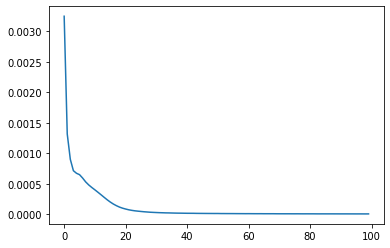

In [ ]:
#Plot de la pérdida
plt.plot(model.loss)
plt.show()

# Guardar el modelo

In [ ]:
PATH = "/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/modelo.h5"
torch.save(model, PATH)

In [ ]:
PATH = "/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/modelo_dict.h5"
torch.save(model.state_dict(), PATH)

# Cargar el modelo

In [ ]:
PATH = "/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/modelo.h5"
model = torch.load(PATH)

In [ ]:
#Later to restore:
PATH = "/content/drive/MyDrive/IngenieriaComputacion/NLP/ProyectoFinal/modelo_dict.h5"
model.load_state_dict(torch.load(PATH))
#model.eval()

<All keys matched successfully>

# Predicciones

In [ ]:
#Transformar salidas en palabras
tgt_voc_rev = {k:v for v,k in tgt_voc.items()}
def get_output(sent):
  #print("Sent:",sent)
  if type(sent) != list:
    sent = sent.tolist()
  return (' '.join([tgt_voc_rev[word] for word in sent if word != BOS_IDX and word !=PAD_IDX])).replace("@@ ","") 

src_voc_rev = {k:v for v,k in src_voc.items()}
def get_input(sent):
  #print("Sent:",sent)
  return (' '.join([src_voc_rev[word] for word in sent if word != BOS_IDX and word !=PAD_IDX])).replace("@@ ","") 

In [ ]:
N_b = 3
decode_function = lambda model, src, src_mask, max_len, start_symbol: beam_search(model, src, src_mask, max_len=max_len, start_symbol=start_symbol, N_b=N_b)
traducciones = list()
originales = list()
for i, sent in enumerate(src_test):
  model.eval()
  x_input = sent
  pred = predict(model, [x_input], decode_function, BOS=BOS_IDX, max_len=80)
  traducciones.append(get_output(pred.tolist()[:80]))
  originales.append(get_output(tgt_test[i][:80]))

In [ ]:
bleu = BLEU()
bleu.corpus_score(traducciones, [originales])

BLEU = 0.99 13.9/2.8/1.3/0.0 (BP = 1.000 ratio = 1.033 hyp_len = 3201 ref_len = 3098)